# Pattern Recognition Assignment 4
## By Sravanth Chowdary Potluri CS20B1006

### Question 1
1. Train a single perceptron and SVM to learn an AND gate with two inputs x1 and x2. Assume that all
the weights of the perceptron are initialized as 0. Show the calulation for each step and also draw the decision
boundary for each updation.

#### Importing the required libraries

In [64]:
import numpy as np
import kvxopt as cvxopt
from kvxopt import matrix,solvers
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sympy import *
import cv2
cvxopt.solvers.options['show_progress']=False

#### Defining the perceptron class

In [65]:
class Perceptron:
    def __init__(self,learning_rate=0.01,epochs=1000):
        self.learning_rate=learning_rate
        self.epochs=epochs

    def __activation_func(self,x):
        return 1 if x>=0 else 0

    def __predict(self,x):
        g=(self.weights.T).dot(x)
        return self.__activation_func(g)

    def __plot(self,X,y):
        color_cond = ['red' if i==1 else 'yellow' for i in y]
        plt.scatter(np.array(X[:, 1]), np.array(X[:, 2]), color=color_cond)
        slope = -(self.weights[1] / self.weights[2])
        intercept = -(self.weights[0] / self.weights[2])
        ax = plt.gca()
        x_vals = np.array(ax.get_xlim())
        y_vals = intercept + (slope * x_vals)
        plt.plot(x_vals, y_vals)
        plt.title('DECISION BOUNDARY')
        plt.show()

    def fit(self, X, y):
        self.X = np.hstack((np.ones((len(X), 1)), X))
        self.y = y
        self.weights = np.zeros(len(self.X[0]))
        self.epoch = 0
        while self.epoch < self.epochs:
            self.epoch = self.epoch + 1
            self.old_W = np.copy(self.weights)
            for index, x in enumerate(self.X):
                self.weights = self.weights + self.learning_rate * (self.y[index] - self.__predict(x)) * x
            if np.array_equal(self.weights, self.old_W):
                break
            print(f'Epoch {self.epoch} --> W: {self.weights}')
            self.__plot(self.X, self.y)

    def predict(self, X):
        if hasattr(self, 'weights'):
            X = np.hstack((np.ones((len(X), 1)), X))
            g = X @ self.weights
            return np.where(g >= 0, 1, 0)
        else:
            print('Please run fit in order to be able to use predict')

    @staticmethod
    def accuracy(y_true,y_pred):
        return np.sum(y_true == y_pred) / len(y_true)

#### Defining the kernel functions

In [66]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x, y, p=2):
    return (1 + np.dot(x, y)) ** p

def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-np.linalg.norm(x - y) ** 2 / (2 * (sigma ** 2)))

#### Defining the SVM class

In [67]:
class SVM:
    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None:
            self.C = float(self.C)

    def fit(self,X,y):
        n_samples, n_features = X.shape
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = self.kernel(X[i], X[j])
        P = cvxopt.matrix(np.outer(y, y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        y = y.astype(np.double)
        A = cvxopt.matrix(y, (1, n_samples))
        b = cvxopt.matrix(0.0)

        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        a = np.ravel(solution['x'])
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print(f"{len(self.a)} support vectors out of {n_samples} points")
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n], sv])

        self.b /= len(self.a)
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w=None


    def project(self,X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b

    def predict(self,X):
        return np.sign(self.project(X))

    def get_nonlinear_equation(self):
        eq = np.zeros(6)
        for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
            eq += a * sv_y * np.asarray([sv[0] ** 2, sv[1] ** 2, 1, sv[0] * 2,sv[1] * 2, 2 * sv[0] * sv[1]])
        return eq

    def __str__(self):
        print("Classifier Details")
        print(f"Alpha: {self.a}")
        print(f"Bias: {self.b}")
        if self.kernel == linear_kernel:
            print(f"Weights: {self.w}")
            print(f"Center Margin Equation: {self.w[0]} x1 + {self.w[1]} x2 +{self.b} = 0")
        else:
            print("Weights: None")
            w = self.get_nonlinear_equation()
            print(f"Center Margin Equation: {w[0]} x1^2 + {w[1]} x2^2 + {w[3]}x1 + {w[4]} x2 + {w[5]} x1x2 + {w[2]} + {self.b} = 0")
        print(f"Support vectors: {self.sv}")
        return ""

    @staticmethod
    def accuracy(y_true, y_pred):
        return np.sum(y_true == y_pred) / len(y_true)

    def plot_decision_boundary(self, X, y):
        color = ['red' if c > 0 else 'blue' for c in y]
        plt.scatter(self.sv[:, 0], self.sv[:, 1], s=100, c="g")
        plt.scatter(X[:, 0], X[:, 1], c=color)
        w = self.w
        b = self.b
        a = -w[0] / w[1]
        xx = np.linspace(-1, 2)
        yy = a * xx - b / w[1]
        plt.plot(xx, yy, "k")
        yy = a * xx - (b + 1) / w[1]
        plt.plot(xx, yy, "k--")
        yy = a * xx - (b - 1) / w[1]
        plt.plot(xx, yy, "k--")
        plt.show()

    def plot_contour(self, X, y):
        X1_train = X[y == -1]
        X2_train = X[y != -1]
        color = ['red' if c > 0 else 'blue' for c in y]
        plt.scatter(self.sv[:, 0], self.sv[:, 1], s=100, c="g")
        plt.scatter(X[:, 0], X[:, 1], c=color)
        X1, X2 = np.meshgrid(np.linspace(0, 7, 20), np.linspace(-5, 10, 20))
        X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
        Z = self.project(X).reshape(X1.shape)
        plt.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
        plt.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1,origin='lower')
        plt.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1,origin='lower')
        plt.show()

#### Training the Perceptron Model

In [68]:
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 0, 0, 1]).T

Epoch 1 --> W: [0.   0.03 0.03]


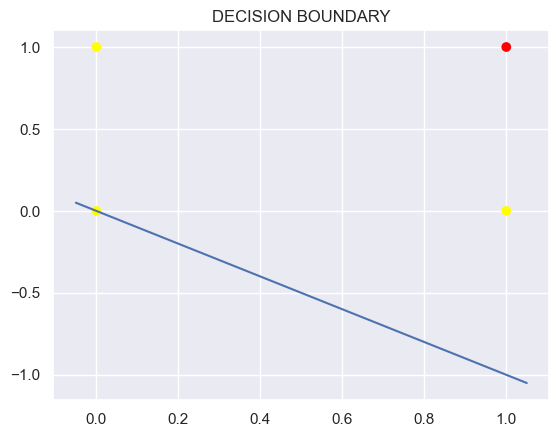

Epoch 2 --> W: [-0.03  0.06  0.03]


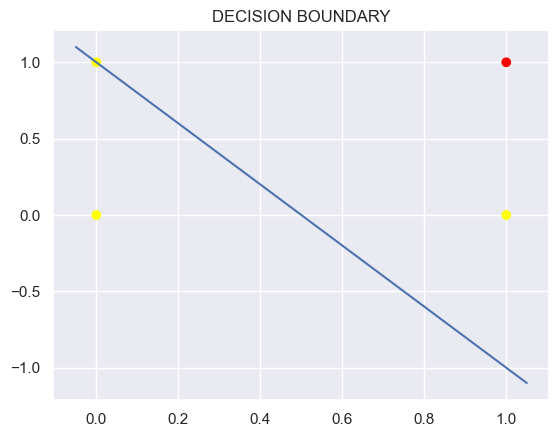

Epoch 3 --> W: [-0.06  0.06  0.03]


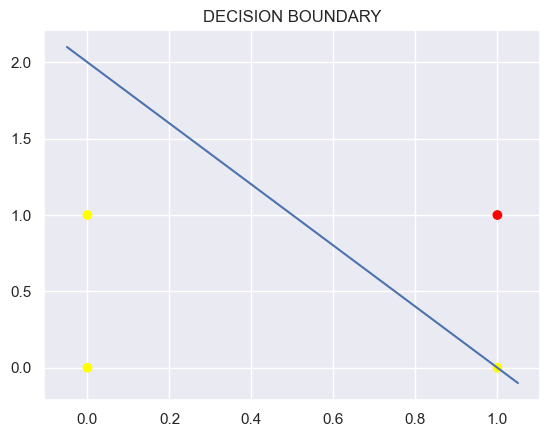

Epoch 4 --> W: [-0.06  0.06  0.06]


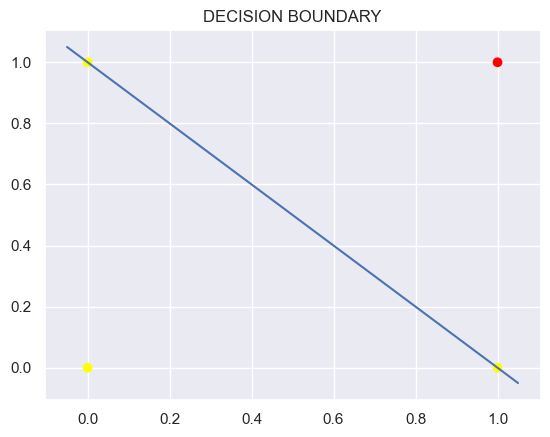

Epoch 5 --> W: [-0.09  0.06  0.03]


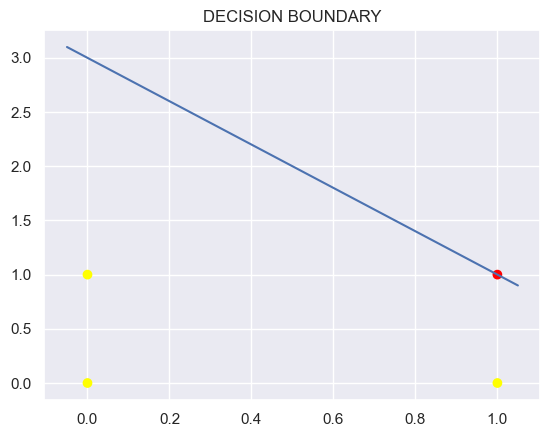

In [69]:
slp = Perceptron(learning_rate=0.03)
slp.fit(X, y)

In [70]:
# displaying the accuracy
print(f"Accuracy: {slp.accuracy(y, slp.predict(X))}")

Accuracy: 1.0


#### Training the SVM Model

In [71]:
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 0, 0, 1]).T

3 support vectors out of 4 points

Accuracy: 1.0

Classifier Details
Alpha: [2.00000036 2.00000036 4.000001  ]
Bias: -3.00000085163083
Weights: [2.00000064 2.00000064]
Center Margin Equation: 2.000000638723123 x1 + 2.000000638723123 x2 +-3.00000085163083 = 0
Support vectors: [[0 1]
 [1 0]
 [1 1]]



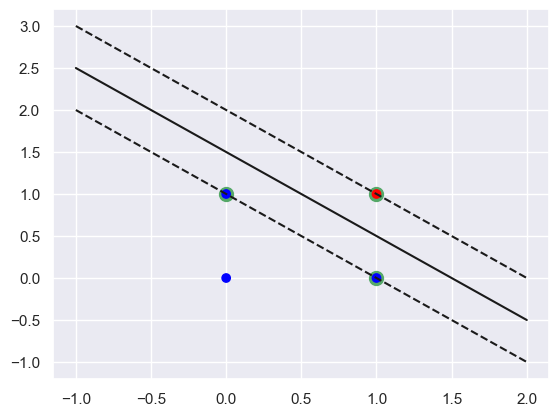

In [72]:
y = np.where(y <= 0, -1, 1)
svm = SVM()
svm.fit(X, y)
y_pred = svm.predict(X)
print(f"\nAccuracy: {slp.accuracy(y, y_pred)}\n")
print(svm)
svm.plot_decision_boundary(X, y)

### Question 2
Train a single perceptron and SVM to learn the two classes in the following table.

| x1 | x2 | w |
|----|----|---|
| 2  | 2  | 1|
| -1 | -3 | 0|
| -1 | 2  | 1|
| 0  | -1 | 0  |
| 1  | 3  | 1|
| -1 | -2 | 0|
| 1  | -2 | 0  |
|-1 |-1| 1|

where x1 and x2 are the inputs and ! is the target class. Assume that all the weights of the perceptron are
initialized as 0 with learning rate 0.01 and 0.5 separately. Also, tabulate the number of iterations required to
converge the perception algorithm with these two learning rates.

#### We use the classes defined above to train the perceptron and the SVM models

In [73]:
X = np.array([[2, 2], [-1, -3], [-1, 2], [0, -1], [1, 3], [-1, -2], [1, -2],[-1, -1]])
y = np.array([1, 0, 1, 0, 1, 0, 0, 1]).T

#### Training the Perceptron Model with learning rate 0.01

Epoch 1 --> W: [0.   0.   0.02]


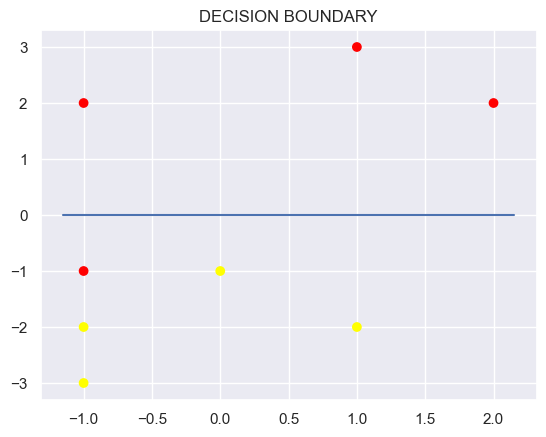

Epoch 2 --> W: [ 0.01 -0.01  0.01]


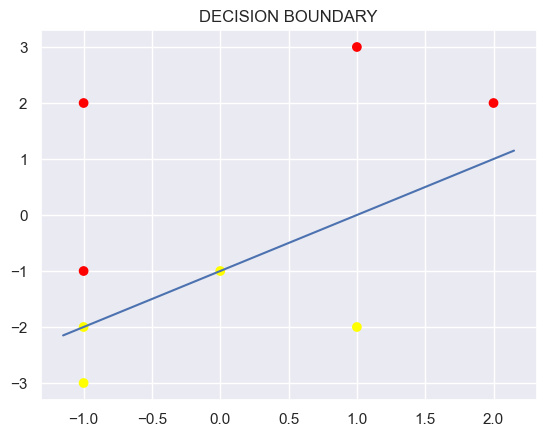

Epoch 3 --> W: [ 0.01 -0.02  0.01]


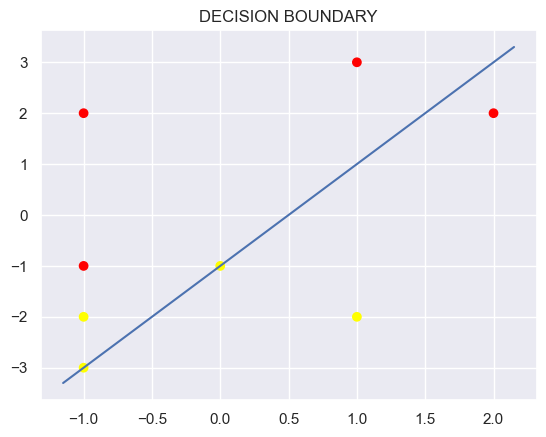

Epoch 4 --> W: [ 0.03 -0.01  0.02]


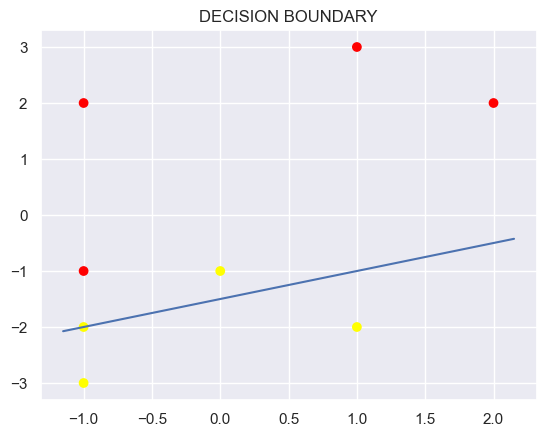

Epoch 5 --> W: [ 0.02 -0.01  0.03]


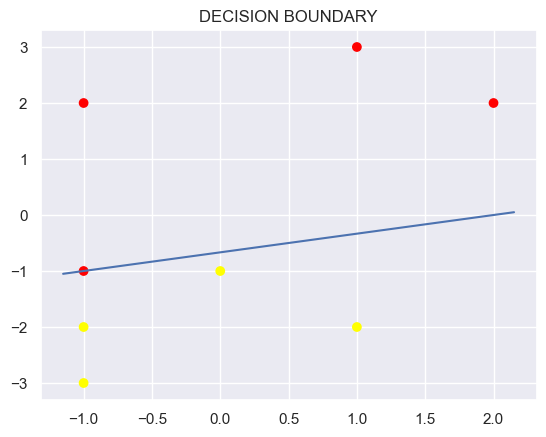

In [74]:
slp=Perceptron(learning_rate=0.01, epochs=20)
slp.fit(X, y)

In [75]:
# displaying the accuracy
print(f"Accuracy: {slp.accuracy(y, slp.predict(X))}")

Accuracy: 1.0


#### Training the Perceptron Model with learning rate 0.5

Epoch 1 --> W: [0. 0. 1.]


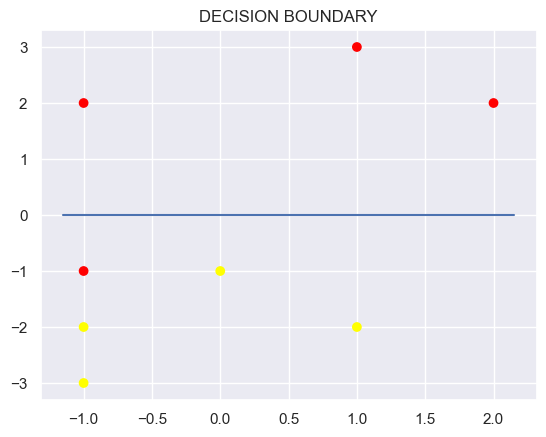

Epoch 2 --> W: [ 0.5 -0.5  0.5]


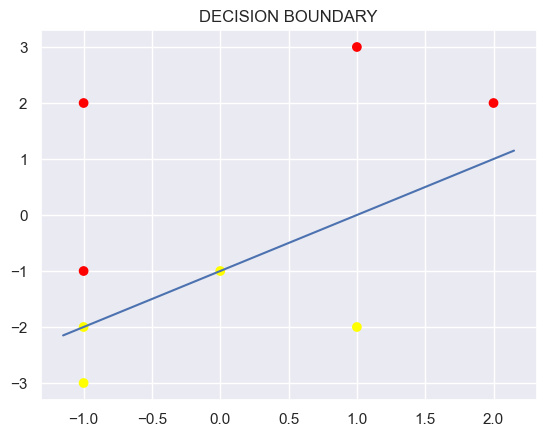

Epoch 3 --> W: [ 0.5 -1.   0.5]


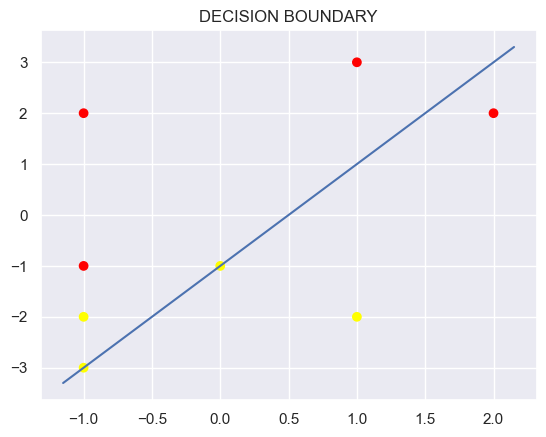

Epoch 4 --> W: [ 1.5 -0.5  1. ]


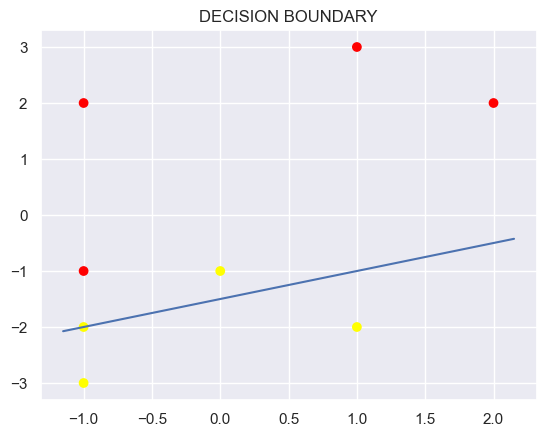

Epoch 5 --> W: [ 1.  -0.5  1.5]


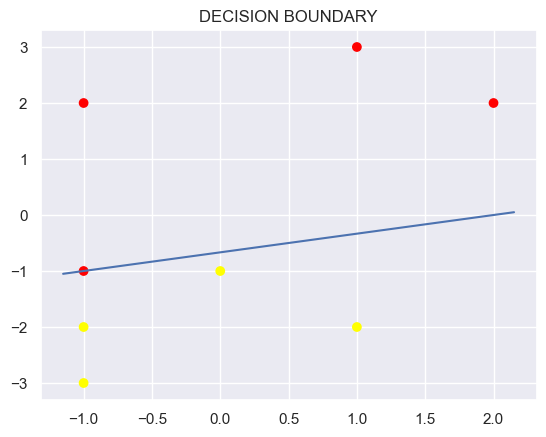

In [76]:
slp = Perceptron(learning_rate=0.5)
slp.fit(X, y)

In [77]:
# displaying the accuracy
print(f"Accuracy: {slp.accuracy(y, slp.predict(X))}")

Accuracy: 1.0


##### it took 5 epochs for the algorithm to converge with both the learning rates

#### Training the SVM Model

In [78]:
X = np.array([[2, 2], [-1, -3], [-1, 2], [0, -1], [1, 3], [-1, -2], [1, -2],[-1, -1]])
y = np.array([1, 0, 1, 0, 1, 0, 0, 1]).T

4 support vectors out of 8 points

Accuracy: 1.0

Classifier Details
Alpha: [0.44320743 3.32962186 0.67037655 3.55679164]
Bias: 0.9999990843677656
Weights: [-2.00000024  1.99999817]
Center Margin Equation: -2.0000002403277857 x1 + 1.9999981687355315 x2 +0.9999990843677656 = 0
Support vectors: [[ 2  2]
 [ 0 -1]
 [-1 -2]
 [-1 -1]]



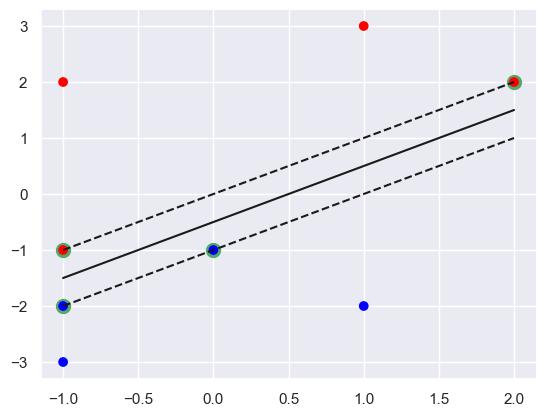

In [79]:
y = np.where(y <= 0, -1, 1)
svm = SVM()
svm.fit(X, y)
y_pred = svm.predict(X)
print(f"\nAccuracy: {slp.accuracy(y, y_pred)}\n")
print(svm)
svm.plot_decision_boundary(X, y)

### Question 3
In the given I set of images from poly1.png to poly14.png, let poly1 to poly 7 belong to class 1 and poly 8 to
poly 14 belong to class 2. Assume that all the weights of the perceptron are initialized as 0 with the learning
rate of 0.01.
1. Identify two discriminant features x1 and x2 for the two target classes w={w1,w2}; Here, w1 - class 1 and w2 - class 2.
2. Generate an input feature vector X for all the images mapping them to a corresponding target classes wi,
where i in (1, 2).
3. Train a single perceptron and SVM to learn the feature vector X mapping to !.
4. Plot and draw the final decision boundary separating the two classes.

#### Training the Perceptron Model

In [80]:
X = []
y = []

for num in range(1, 15):
    img = cv2.imread(f'poly/poly{num}.png')
    x1 = sum((255 > np.average(i) > 0) for i in img[0])/len(img[0])
    x2 = sum((255 > np.average(i[0]) > 0) for i in img)/len(img)
    X.append([x1, x2])
    y.append(0 if num <= 7 else 1)
X = np.array(X)
y = np.array(y).T

Epoch 1 --> W: [0.         0.03       0.02953416]


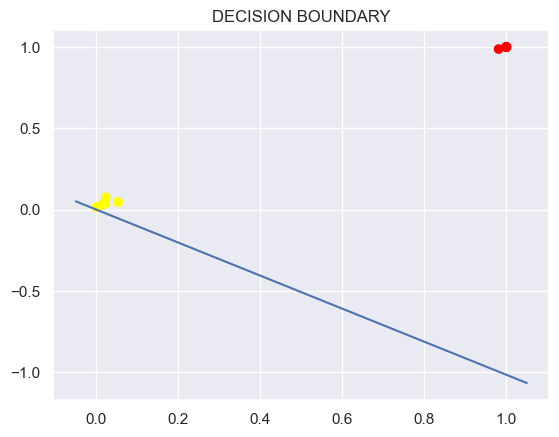

Epoch 2 --> W: [-0.03        0.03        0.02906832]


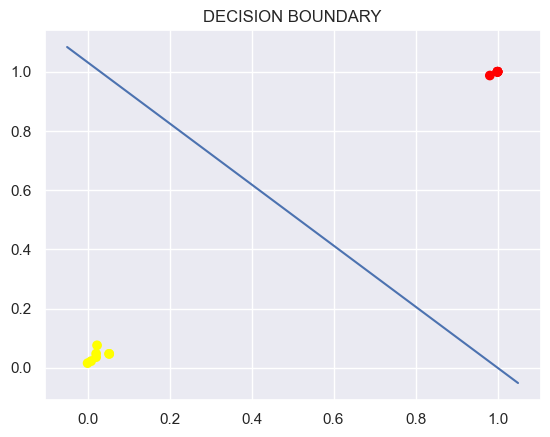

In [81]:
slp = Perceptron(learning_rate=0.03)
slp.fit(X,y)

In [82]:
# displaying the accuracy
print(f"Accuracy: {slp.accuracy(y, slp.predict(X))}")

Accuracy: 1.0


#### Training the SVM Model

In [83]:
X = []
y = []

for num in range(1, 15):
    img = cv2.imread(f'poly/poly{num}.png')
    x1 = sum((255 > np.average(i) > 0) for i in img[0])/len(img[0])
    x2 = sum((255 > np.average(i[0]) > 0) for i in img)/len(img)
    X.append([x1, x2])
    y.append(0 if num <= 7 else 1)
X = np.array(X)
y = np.array(y).T

4 support vectors out of 14 points

Accuracy: 1.0

Classifier Details
Alpha: [7.87778490e-05 5.72450588e-01 5.72450588e-01 1.14497993e+00]
Bias: -1.1063445602479223
Weights: [1.06321819 1.07681331]
Center Margin Equation: 1.0632181904682394 x1 + 1.0768133053064597 x2 +-1.1063445602479223 = 0
Support vectors: [[0.02304147 0.07575758]
 [0.05263158 0.046875  ]
 [0.05263158 0.046875  ]
 [0.98122066 0.98734177]]



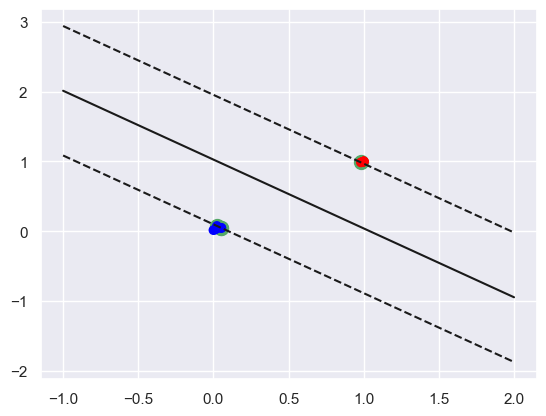

In [84]:
y = np.where(y <= 0, -1, 1)
svm = SVM()
svm.fit(X, y)
y_pred = svm.predict(X)
print(f"\nAccuracy: {slp.accuracy(y, y_pred)}\n")
print(svm)
svm.plot_decision_boundary(X, y)

### Question 4
From the iris dataset, choose the 'petal length', 'sepal width' for setosa, versicolor and virginica
owers. Learn
a decision boundary for the two features using a single perceptron and SVM. Assume that all the weights
of the perceptron are initialized as 0 with the learning rate of 0.01. Draw the decision boundary.

#### Processing the Iris Dataset

In [85]:
iris_dataset = pd.read_csv("iris.csv",index_col=False)
print(iris_dataset.head())

   sepal_length  sepal_width  petal_length  petal_width      species
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa


In [86]:
iris_data = iris_dataset.drop(['sepal_length','petal_width'], axis=1)
print(iris_data)

     sepal_width  petal_length         species
0            3.5           1.4     Iris-setosa
1            3.0           1.4     Iris-setosa
2            3.2           1.3     Iris-setosa
3            3.1           1.5     Iris-setosa
4            3.6           1.4     Iris-setosa
..           ...           ...             ...
145          3.0           5.2  Iris-virginica
146          2.5           5.0  Iris-virginica
147          3.0           5.2  Iris-virginica
148          3.4           5.4  Iris-virginica
149          3.0           5.1  Iris-virginica

[150 rows x 3 columns]


In [87]:
iris_data_12 = iris_data[iris_data['species']!='Iris-virginica']
print(iris_data_12)

    sepal_width  petal_length          species
0           3.5           1.4      Iris-setosa
1           3.0           1.4      Iris-setosa
2           3.2           1.3      Iris-setosa
3           3.1           1.5      Iris-setosa
4           3.6           1.4      Iris-setosa
..          ...           ...              ...
95          3.0           4.2  Iris-versicolor
96          2.9           4.2  Iris-versicolor
97          2.9           4.3  Iris-versicolor
98          2.5           3.0  Iris-versicolor
99          2.8           4.1  Iris-versicolor

[100 rows x 3 columns]


In [88]:
var=[]
for i in range(len(iris_data_12)):
    if iris_data_12['species'].iloc[i]=='Iris-setosa':
        var.append(1)
    else:
        var.append(-1)
iris_data_12['var'] = var
iris_data_12 = iris_data_12.drop(['species'],axis=1)
print(iris_data_12)

    sepal_width  petal_length  var
0           3.5           1.4    1
1           3.0           1.4    1
2           3.2           1.3    1
3           3.1           1.5    1
4           3.6           1.4    1
..          ...           ...  ...
95          3.0           4.2   -1
96          2.9           4.2   -1
97          2.9           4.3   -1
98          2.5           3.0   -1
99          2.8           4.1   -1

[100 rows x 3 columns]


/var/folders/sq/_g9d40851fd2n842lj79vc680000gn/T/ipykernel_89643/961369683.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iris_data_12['var'] = var


In [89]:
iris_data_13 = iris_data[iris_data['species']!='Iris-versicolor']
print(iris_data_13)

     sepal_width  petal_length         species
0            3.5           1.4     Iris-setosa
1            3.0           1.4     Iris-setosa
2            3.2           1.3     Iris-setosa
3            3.1           1.5     Iris-setosa
4            3.6           1.4     Iris-setosa
..           ...           ...             ...
145          3.0           5.2  Iris-virginica
146          2.5           5.0  Iris-virginica
147          3.0           5.2  Iris-virginica
148          3.4           5.4  Iris-virginica
149          3.0           5.1  Iris-virginica

[100 rows x 3 columns]


In [90]:
var=[]
for i in range(len(iris_data_13)):
    if iris_data_13['species'].iloc[i]=='Iris-setosa':
        var.append(1)
    else:
        var.append(-1)
iris_data_13['var'] = var
iris_data_13 = iris_data_13.drop(['species'],axis=1)
print(iris_data_13)

     sepal_width  petal_length  var
0            3.5           1.4    1
1            3.0           1.4    1
2            3.2           1.3    1
3            3.1           1.5    1
4            3.6           1.4    1
..           ...           ...  ...
145          3.0           5.2   -1
146          2.5           5.0   -1
147          3.0           5.2   -1
148          3.4           5.4   -1
149          3.0           5.1   -1

[100 rows x 3 columns]


/var/folders/sq/_g9d40851fd2n842lj79vc680000gn/T/ipykernel_89643/2278249848.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iris_data_13['var'] = var


In [91]:
iris_data_23 = iris_data[iris_data['species']!='Iris-setosa']
print(iris_data_23)

     sepal_width  petal_length          species
50           3.2           4.7  Iris-versicolor
51           3.2           4.5  Iris-versicolor
52           3.1           4.9  Iris-versicolor
53           2.3           4.0  Iris-versicolor
54           2.8           4.6  Iris-versicolor
..           ...           ...              ...
145          3.0           5.2   Iris-virginica
146          2.5           5.0   Iris-virginica
147          3.0           5.2   Iris-virginica
148          3.4           5.4   Iris-virginica
149          3.0           5.1   Iris-virginica

[100 rows x 3 columns]


In [92]:
var=[]
for i in range(len(iris_data_23)):
    if iris_data_23['species'].iloc[i]=='Iris-versicolor':
        var.append(1)
    else:
        var.append(-1)
iris_data_23['var'] = var
iris_data_23 = iris_data_23.drop(['species'],axis=1)
print(iris_data_23)

     sepal_width  petal_length  var
50           3.2           4.7    1
51           3.2           4.5    1
52           3.1           4.9    1
53           2.3           4.0    1
54           2.8           4.6    1
..           ...           ...  ...
145          3.0           5.2   -1
146          2.5           5.0   -1
147          3.0           5.2   -1
148          3.4           5.4   -1
149          3.0           5.1   -1

[100 rows x 3 columns]


/var/folders/sq/_g9d40851fd2n842lj79vc680000gn/T/ipykernel_89643/491270488.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iris_data_23['var'] = var


#### Training the Perceptron Model

In [93]:
data_aug_12 = pd.DataFrame(list(zip(iris_data_12['petal_length'],iris_data_12['sepal_width'], [1 for i in range(len(iris_data_12))],iris_data_12['var'])), columns=['petal_length','sepal_width','augment','var'])
print(data_aug_12)

    petal_length  sepal_width  augment  var
0            1.4          3.5        1    1
1            1.4          3.0        1    1
2            1.3          3.2        1    1
3            1.5          3.1        1    1
4            1.4          3.6        1    1
..           ...          ...      ...  ...
95           4.2          3.0        1   -1
96           4.2          2.9        1   -1
97           4.3          2.9        1   -1
98           3.0          2.5        1   -1
99           4.1          2.8        1   -1

[100 rows x 4 columns]


In [94]:
data_aug_13 = pd.DataFrame(list(zip(iris_data_13['petal_length'],iris_data_13['sepal_width'], [1 for i in range(len(iris_data_13))],iris_data_13['var'])), columns=['petal_length','sepal_width','augment','var'])
print(data_aug_13)

    petal_length  sepal_width  augment  var
0            1.4          3.5        1    1
1            1.4          3.0        1    1
2            1.3          3.2        1    1
3            1.5          3.1        1    1
4            1.4          3.6        1    1
..           ...          ...      ...  ...
95           5.2          3.0        1   -1
96           5.0          2.5        1   -1
97           5.2          3.0        1   -1
98           5.4          3.4        1   -1
99           5.1          3.0        1   -1

[100 rows x 4 columns]


In [95]:
data_aug_23 = pd.DataFrame(list(zip(iris_data_23['petal_length'],iris_data_23['sepal_width'], [1 for i in range(len(iris_data_23))],iris_data_23['var'])), columns=['petal_length','sepal_width','augment','var'])
print(data_aug_23)

    petal_length  sepal_width  augment  var
0            4.7          3.2        1    1
1            4.5          3.2        1    1
2            4.9          3.1        1    1
3            4.0          2.3        1    1
4            4.6          2.8        1    1
..           ...          ...      ...  ...
95           5.2          3.0        1   -1
96           5.0          2.5        1   -1
97           5.2          3.0        1   -1
98           5.4          3.4        1   -1
99           5.1          3.0        1   -1

[100 rows x 4 columns]


##### Function to split the data into features and target variable

In [96]:
def split(data_aug):
    data_up = data_aug.copy()
    for i in range(len(data_up)):
        if(data_up['var'][i] == 1):
            data_up['petal_length'][i] = - data_up['petal_length'][i]
            data_up['sepal_width'][i] = -data_up['sepal_width'][i]
            data_up['augment'][i] = -data_up['augment'][i]
    # print(data_up)
    data_up = data_up.drop(['var'], axis=1)
    data_up = np.array(data_up)
    # print(data_up)

    labels = data_aug['var']
    labels = np.array(labels)
    # print(labels)

    return (data_up, labels)

In [ ]:
data_up_12, labels_12 = split(data_aug_12)
data_up_13, labels_13 = split(data_aug_13)
data_up_23, labels_23 = split(data_aug_23)

##### Function to train the perceptron model

In [98]:
def Perceptron_Train(data_up, labels, eta):

    threshold = 5000
    A = np.zeros(len(data_up[0]))

    # print(A)

    for epoch in range(threshold):
        ctr = 0

        for inp, label in zip(data_up, labels):
            summation = np.dot(inp, A)
            if summation <= 0:
                A += eta*inp
                ctr = 0

            else:
                ctr+=1

        if ctr == len(data_up):     #Until all input is correctly classified
            break
    print(epoch)
    return A

In [99]:
x1, x2, b = symbols('x1 x2 1')
P = np.array([x1,x2, b])
print(P)

[x1 x2 1]


In [100]:
eta = 0.01
A_12 = Perceptron_Train(data_up_12, labels_12, eta)
print(A_12)

3
[ 0.052 -0.041 -0.01 ]


In [101]:
Percep_equation_12 = np.dot(A_12.T, P)
print("Decision Boundary between Setosa and Versicolor: ", Percep_equation_12, ' = 0')

Decision Boundary between Setosa and Versicolor:  -0.01*1 + 0.052*x1 - 0.041*x2  = 0


In [102]:
eta = 0.01
A_13 = Perceptron_Train(data_up_13, labels_13, eta)
print(A_13)

2
[ 0.032 -0.037 -0.01 ]


In [103]:
Percep_equation_13 = np.dot(A_13.T, P)
print("Decision Boundary between Setosa and Virginica: ", Percep_equation_13, ' = 0')

Decision Boundary between Setosa and Virginica:  -0.01*1 + 0.032*x1 - 0.037*x2  = 0


In [104]:
eta = 0.01
A_23 = Perceptron_Train(data_up_23, labels_23, eta)
print(A_23)

4999
[ 1.296 -0.837 -3.43 ]


In [105]:
Percep_equation_23 = np.dot(A_23.T, P)
print("Decision Boundary between Versicolor and Virginica: ", Percep_equation_23, ' = 0')

Decision Boundary between Versicolor and Virginica:  -3.42999999999997*1 + 1.29600000000016*x1 - 0.837*x2  = 0


#### Plotting the Decision Boundaries

##### Function to plot the decision boundaries

In [106]:
def plot_percep(A, data_aug):
    a = np.linspace(-1,7,100)
    b = -a*A[0]/A[1] - A[2]/A[1]

    sns.set(style="darkgrid")
    sns.lmplot(x='petal_length',y='sepal_width', data=data_aug, fit_reg=False, hue='var', legend=True)
    plt.plot(a,b)
    plt.show()

##### Plotting the decision boundary between Setosa and Versicolor

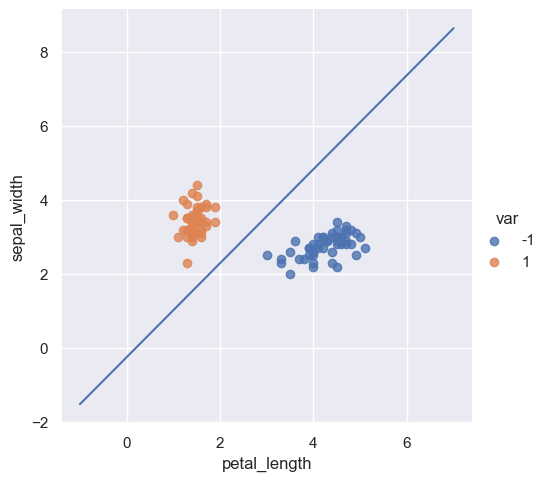

In [107]:
plot_percep(A_12,data_aug_12)

##### Plotting the decision boundary between Setosa and Virginica

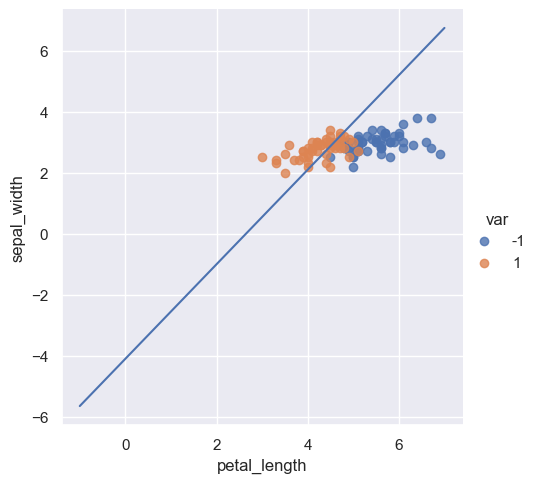

In [108]:
plot_percep(A_23,data_aug_23)

##### Plotting the decision boundary between Versicolor and Virginica

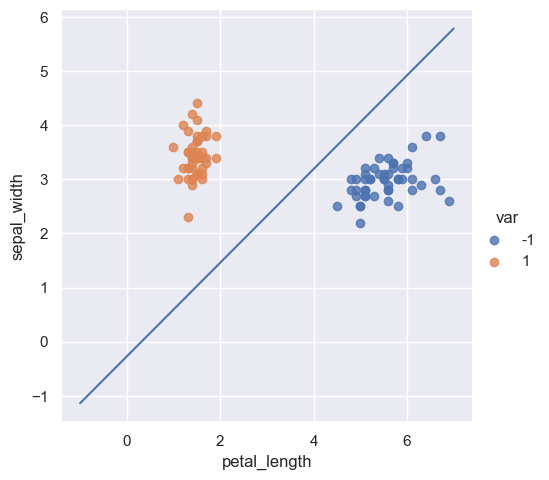

In [109]:
plot_percep(A_13, data_aug_13)

##### Plotting all the decision boundaries together

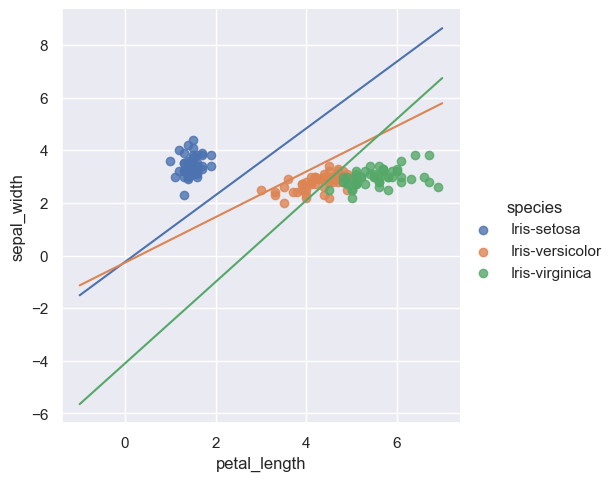

In [110]:
a = np.linspace(-1,7,100)
b_12 = -a*A_12[0]/A_12[1] - A_12[2]/A_12[1]
b_13 = -a*A_13[0]/A_13[1] - A_13[2]/A_13[1]
b_23 = -a*A_23[0]/A_23[1] - A_23[2]/A_23[1]
sns.set(style="darkgrid")
sns.lmplot(x='petal_length',y='sepal_width', data=iris_data, fit_reg=False, hue='species', legend=True)
plt.plot(a,b_12)
plt.plot(a,b_13)
plt.plot(a,b_23)
plt.show()

#### Training The SVM Model

In [111]:
def data_svm_split(iris):
    X = iris[['petal_length','sepal_width']]
    X = np.array(X)

    Y = iris['var']
    Y = np.array(Y).reshape(len(iris),1)

    return (X,Y)

In [112]:
X_12,Y_12 = data_svm_split(iris_data_12)
X_13,Y_13 = data_svm_split(iris_data_13)
X_23,Y_23 = data_svm_split(iris_data_23)

##### Function to train the SVM model

In [113]:
def SVM_Train(X,Y):
    m = len(X)
    P = matrix(np.multiply(np.dot(Y, Y.T), np.dot(X, X.T)))
    q = matrix(np.ones(m) * -1)
    g1 = np.asarray(np.diag(np.ones(m) * -1))

    print(np.array(g1).shape)
    h = matrix(np.zeros(m))
    A = np.reshape((Y.T), (1,m))
    b=[[0]]

    P = matrix(P,(m,m),'d') #dense
    A = matrix(A,(1,m),'d')
    g1 = matrix(g1,(m,m),'d')
    b = matrix(b,(1,1),'d')

    sol = solvers.qp(P, q, g1, h, A, b)
    alpha = np.array(sol['x'])
    ind = (alpha > 1e-4).flatten()
    print(ind)

    W = np.dot(np.transpose(alpha*Y),X)
    print(W)

    for i in range(m):
        if ind[i] == True:
            W0 = Y[i] - np.dot(X[i],W.T)
            print
            break

    print(W0)

    return (W, W0)

In [114]:
x1, x2 = symbols('x1 x2')
P_SVM = np.array([x1,x2])
print(P_SVM)

[x1 x2]


In [115]:
W_12,W0_12 = SVM_Train(X_12,Y_12)

(100, 100)
[False False False False False False False False False False False False
 False False False False False False False False False False False False
  True False False False False False False False False False False False
 False False False False False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True False]
[[-1.25714286  0.68571428]]
[1.05714287]


In [116]:
SVM_equation_12 = np.dot(W_12[0].T, P_SVM) + W0_12[0]
print("Decision Boundary between Setosa and Versicolor: ", SVM_equation_12, ' = 0')

Decision Boundary between Setosa and Versicolor:  -1.2571428593549*x1 + 0.685714284475986*x2 + 1.05714286555595  = 0


In [117]:
W_13,W0_13 = SVM_Train(X_13,Y_13)

(100, 100)
[False False False False False False False False False False False False
 False False False False False False False False False False False False
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
[[-0.68692206  0.23778071]]
[1.49669752]


In [118]:
SVM_equation_13 = np.dot(W_13[0].T, P_SVM) + W0_13[0]
print("Decision Boundary between Setosa and Virginica: ", SVM_equation_13, ' = 0')

Decision Boundary between Setosa and Virginica:  -0.686922063673953*x1 + 0.237780706899677*x2 + 1.49669751752161  = 0


In [119]:
W_23,W0_23 = SVM_Train(X_23,Y_23)

(100, 100)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
[[ 6.10351562e-05 -3.05175781e-04]]
[1.0006897]


In [120]:
SVM_equation_23 = np.dot(W_23[0].T, P_SVM) + W0_23[0]
print("Decision Boundary between Versicolor and Virginica: ", SVM_equation_23, ' = 0')

Decision Boundary between Versicolor and Virginica:  6.103515625e-5*x1 - 0.00030517578125*x2 + 1.00068969726562  = 0


##### function to plot the decision boundaries

In [121]:
def plot_SVM(W,W0, data_aug):
    a = np.linspace(-1,7,100)
    b = -a*W[0][0]/W[0][1] - W0[0]/W[0][1]
    sns.set(style="darkgrid")
    sns.lmplot(x='petal_length',y='sepal_width', data=data_aug, fit_reg=False, hue='var', legend=True)
    plt.plot(a,b)
    plt.show()

##### Plotting the decision boundary between Setosa and Versicolor

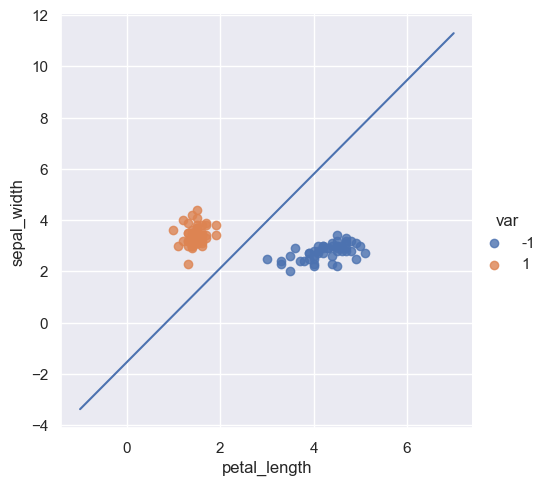

In [122]:
plot_SVM(W_12,W0_12,iris_data_12)

##### Plotting the decision boundary between Setosa and Virginica

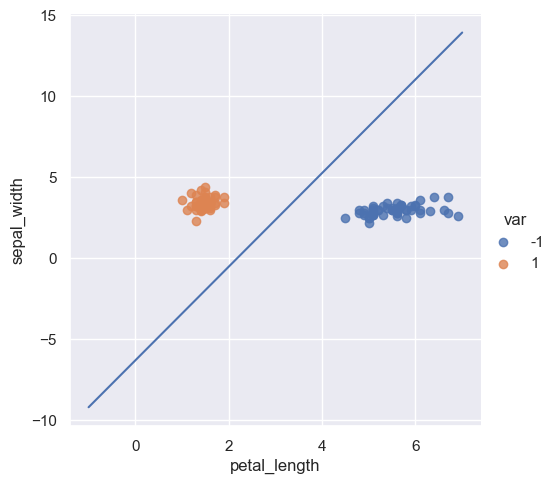

In [123]:
plot_SVM(W_13,W0_13,iris_data_13)

##### Plotting the decision boundary between Versicolor and Virginica

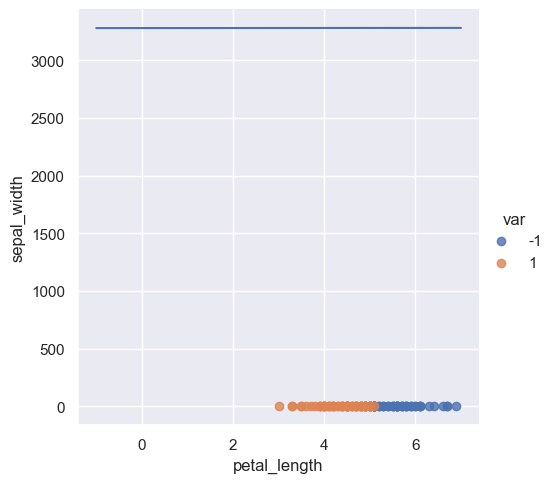

In [124]:
plot_SVM(W_23,W0_23,iris_data_23)

Clearly the decision boundary between versicolor and virginica does not seem right. This is because the data is not linearly separable

##### Plotting Only The first two decision boundaries

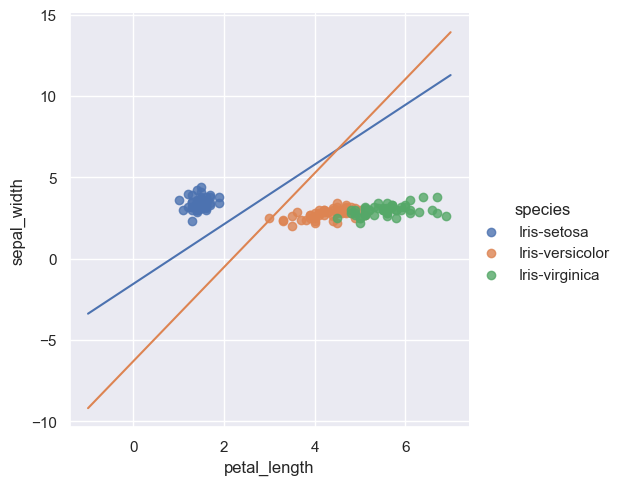

In [125]:
a = np.linspace(-1,7,100)
b_12 = -a*W_12[0][0]/W_12[0][1] - W0_12[0]/W_12[0][1]
b_13 = -a*W_13[0][0]/W_13[0][1] - W0_13[0]/W_13[0][1]
sns.set(style="darkgrid")
sns.lmplot(x='petal_length',y='sepal_width', data=iris_data, fit_reg=False, hue='species', legend=True)

plt.plot(a,b_12)
plt.plot(a,b_13)
plt.show()

##### Plotting The Third Decision Boundary Along With The First Two

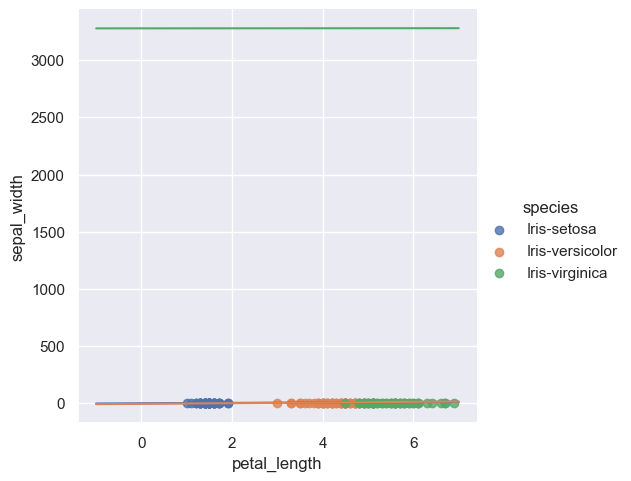

In [126]:
a = np.linspace(-1,7,100)
b_12 = -a*W_12[0][0]/W_12[0][1] - W0_12[0]/W_12[0][1]
b_13 = -a*W_13[0][0]/W_13[0][1] - W0_13[0]/W_13[0][1]
b_23 = -a*W_23[0][0]/W_23[0][1] - W0_23[0]/W_23[0][1]
sns.set(style="darkgrid")
sns.lmplot(x='petal_length',y='sepal_width', data=iris_data, fit_reg=False, hue='species', legend=True)
plt.plot(a,b_12)
plt.plot(a,b_13)
plt.plot(a,b_23)
plt.show()

# THE-END